In [1]:
from ModularCirc.Models.NaghaviModelRLC import NaghaviModelRLC, NaghaviModelParameters
from ModularCirc.Solver import Solver

import matplotlib.pyplot as plt
import numpy  as np

Define the duration of the simulation in terms of the number of cycles, the duration of a time cycle (ms) and the duration of a time step.

In [2]:
TEMPLATE_TIME_SETUP_DICT = {
    'name'    :  'TimeTest',
    'ncycles' :  40,
    'tcycle'  :  800.,
    'dt'      :  1.0,
 }

The parameters object used to constrain the model.

In [19]:
parobj = NaghaviModelParameters()
parobj.set_chamber_comp('lv', tau=360.)
parobj.set_chamber_comp('la', tau=160.)
parobj.set_rlc_comp('ao', c=0.025)
parobj.set_rlc_comp('ao', l=1e-3)

Define an instance of the model using the parameter object.

In [20]:
model = NaghaviModelRLC(TEMPLATE_TIME_SETUP_DICT, parobj=parobj)

Naghavi Model parameters set: 
 * Component - ao
  - r       : 3.200e+04
  - c       : 2.500e-02
  - l       : 1.000e-03
  - v_ref   : 1.000e+02
  - v       : 1.300e+02
  - p       : None

 * Component - art
  - r       : 1.500e+05
  - c       : 2.500e-02
  - l       : 0.000e+00
  - v_ref   : 5.000e+01
  - v       : 1.092e+03
  - p       : None

 * Component - ven
  - r       : 1.200e+03
  - c       : 1.000e+00
  - l       : 0.000e+00
  - v_ref   : 2.800e+03
  - v       : 3.780e+03
  - p       : None

 * Component - av
  - r       : 8.000e+02
  - max_func : <function relu_max at 0x158478040>

 * Component - mv
  - r       : 5.500e+02
  - max_func : <function relu_max at 0x158478040>

 * Component - la
  - E_pas   : 6.000e+01
  - E_act   : 5.867e+01
  - V_ref   : 1.000e+01
  - activation_function : <function activation_function_2 at 0x1584783a0>
  - t_max   : 1.500e+02
  - t_tr    : 2.250e+02
  - tau     : 1.600e+02
  - delay   : 1.000e+02
  - V       : 9.360e+01
  - P       : None

 * 

Define a solver to run the model.

In [21]:
solver = Solver(model=model)
solver.setup()

 -- Variable v_ao added to the principal variable key list.
    - name of update function: lambda chamber_volume_rate_change
 -- Variable v_art added to the principal variable key list.
    - name of update function: lambda chamber_volume_rate_change
 -- Variable v_ven added to the principal variable key list.
    - name of update function: lambda chamber_volume_rate_change
 -- Variable v_la added to the principal variable key list.
    - name of update function: lambda chamber_volume_rate_change
 -- Variable v_lv added to the principal variable key list.
    - name of update function: lambda chamber_volume_rate_change
 -- Variable p_lv added to the principal variable key list.
    - name of update function: lamda constant elastance dpdt
 -- Variable q_av added to the secondary variable key list.
    - name of update function: lambda non_ideal_diode_flow + max_func
 -- Variable p_ao added to the principal variable key list.
    - name of update function: lambda grounded_capacitor_model

In [22]:
solver.model.commponents['ao']._Q_o.dudt_name

'lambda resistor_impedance_flux_rate'

In [23]:
solver.solve()

/Users/mbalmus/Desktop/Projects/Onboarding/MainProject/ModularCirc/ModularCirc/Solver.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [fun(*y[inds]) for fun, inds in zip(funcs, ids)]


In [24]:
ind1 = -2*model.time_object.n_c+1
ind2 = -1

v_lv = solver.model.commponents['lv'].V.values[ind1:ind2]
p_lv = solver.model.commponents['lv'].P_i.values[ind1:ind2]

v_la = solver.model.commponents['la'].V.values[ind1:ind2]
p_la = solver.model.commponents['la'].P_i.values[ind1:ind2]

t = model.time_object._sym_t[ind1:ind2].values
t -= t[0]

q_mv = solver.model.commponents['mv'].Q_i.values[ind1:ind2]
q_av = solver.model.commponents['av'].Q_i.values[ind1:ind2]
p_ao = solver.model.commponents['ao'].P_i.values[ind1:ind2]
q_ao = solver.model.commponents['ao'].Q_o.values[ind1:ind2]

af_lv = np.vectorize(model.commponents['lv']._af) 
af_la = np.vectorize(model.commponents['la']._af) 
tc = model.time_object._cycle_t[ind1:ind2]

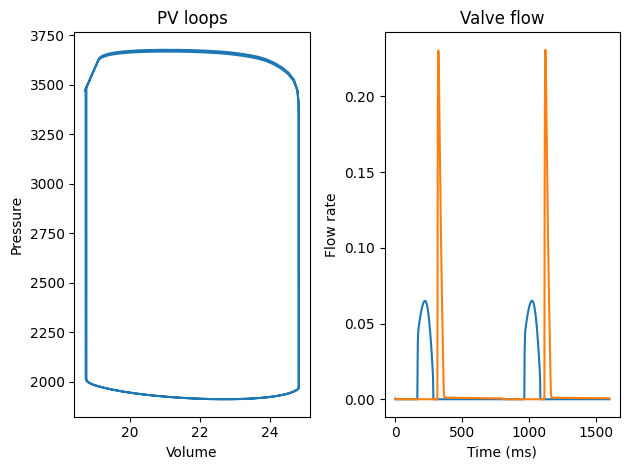

In [25]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(v_lv, p_lv)
ax[0].set_title('PV loops')
ax[0].set_ylabel('Pressure')
ax[0].set_xlabel('Volume')

ax[1].plot(t, q_mv)
ax[1].plot(t, q_av)
ax[1].set_title('Valve flow')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Flow rate')

plt.tight_layout()
plt.show()

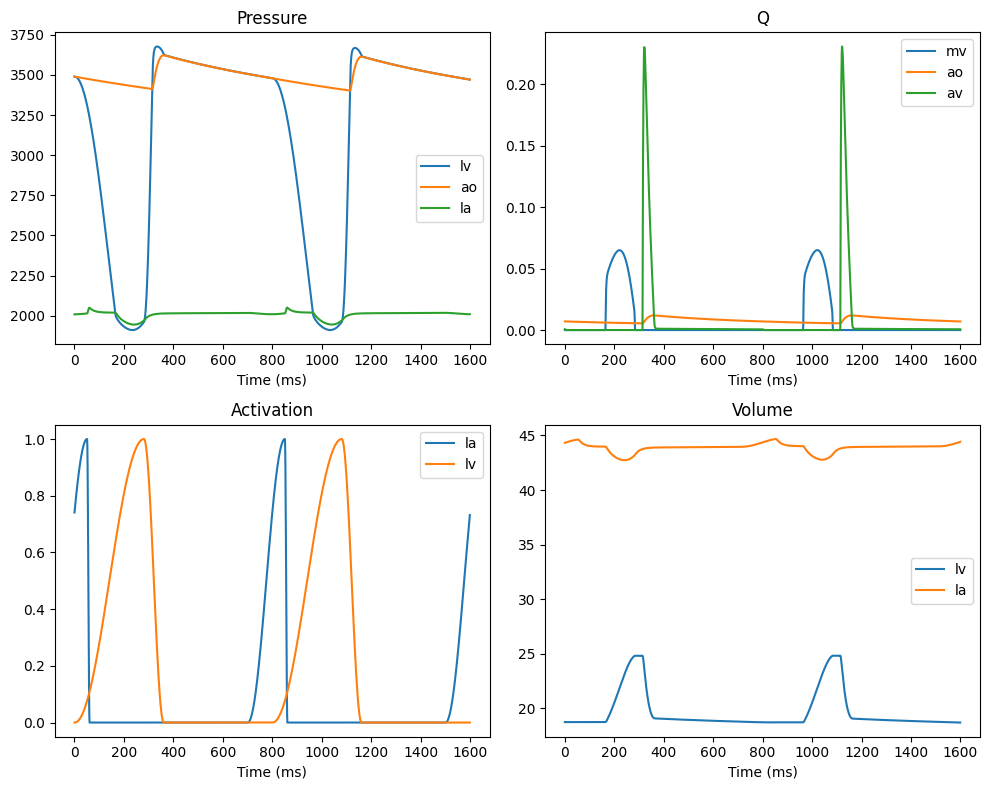

In [26]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

ax2[0][0].plot(t, p_lv, label='lv')
ax2[0][0].plot(t, p_ao, label='ao')
ax2[0][0].plot(t, p_la, label='la')
ax2[0][0].set_title('Pressure')
ax2[0][0].set_xlabel('Time (ms)')
ax2[0][0].legend()

ax2[0][1].plot(t, q_mv, label='mv')
ax2[0][1].plot(t, q_ao, label='ao')
ax2[0][1].plot(t, q_av, label='av')
ax2[0][1].set_title('Q')
ax2[0][1].set_xlabel('Time (ms)')
ax2[0][1].legend()

ax2[1][0].plot(t, af_la(tc), label='la')
ax2[1][0].plot(t, af_lv(tc), label='lv')
ax2[1][0].set_title('Activation')
ax2[1][0].set_xlabel('Time (ms)')
ax2[1][0].legend()

ax2[1][1].plot(t, v_lv, label='lv')
ax2[1][1].plot(t, v_la, label='la')
ax2[1][1].set_title('Volume')
ax2[1][1].set_xlabel('Time (ms)')
ax2[1][1].legend()

plt.tight_layout()
plt.show()